## **Day 2: Classification and Clustering – Movement Prediction and Market Patterns :**

# **Clustering :**

In [46]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline

from sklearn.metrics import silhouette_score, davies_bouldin_score

### *Preparing Features for Clustering:*

In [47]:
df = pd.read_csv(r'cleaned_data.csv')
df.shape

(2738, 18)

In [48]:
df = df.set_index('timestamp')

In [49]:
df.drop(columns=['day','target'],inplace=True)

In [50]:
df.head()

,open,high,low,close,volume,year,returns,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7
timestamp,,,,,,,,,,,,,,,
2018-01-14,14210.00,14339.50,12569.20,13474.99,17017.894329,2018,-0.05,14506.92,14370.08,16249.23,14506.92,12764.61,940.96,49.66,-0.17
2018-01-15,13477.98,14249.99,13147.79,13539.93,14652.094705,2018,0.00,14124.77,14146.31,15356.54,14124.77,12893.00,665.23,44.25,-0.17
2018-01-16,13500.00,13542.93,9035.00,10900.00,63401.169175,2018,-0.19,13930.11,13994.71,15032.60,13930.11,12827.63,595.41,44.83,-0.09
2018-01-17,10899.99,11680.99,9037.94,10988.79,72331.796646,2018,0.01,13430.11,13221.04,15740.08,13430.11,11120.15,1247.52,30.94,-0.24
2018-01-18,10972.59,11878.82,10435.33,10961.97,48464.434937,2018,-0.00,12870.36,12662.97,15368.72,12870.36,10371.99,1349.27,31.71,-0.26


### *using PCA to Decrese features and then trying to Cluster :*
- since custering model is not so good

In [53]:
df_cluster = df.copy()

In [54]:
scaler = joblib.load("clus_scaler.pkl")

In [55]:
# scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [56]:
# joblib.dump(scaler,'clus_scaler.pkl')

In [57]:
pca = joblib.load('pca_1.pkl')

In [58]:
# pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [59]:
# joblib.dump(pca,'pca_1.pkl')

In [60]:
print("Original shape:", X_scaled.shape)
print("PCA shape (90% var):", X_pca.shape)


Original shape: (2738, 15)
PCA shape (90% var): (2738, 4)


In [61]:
X_pca

array([[-2.30521689, -1.55819145, -1.54567587,  0.22054533],
       [-2.40332064, -1.75995477, -0.42177091, -0.66529497],
       [-2.56022339, -1.34885089, -4.43412241,  3.06993551],
       ...,
       [ 9.43709162,  1.25430748, -0.1886203 , -0.06939688],
       [ 9.61111063,  1.16340911,  0.05254009, -0.23629153],
       [ 9.84978064,  1.35428708,  0.0589763 , -0.2138724 ]],
      shape=(2738, 4))

In [62]:
inertia = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_pca)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca, labels))

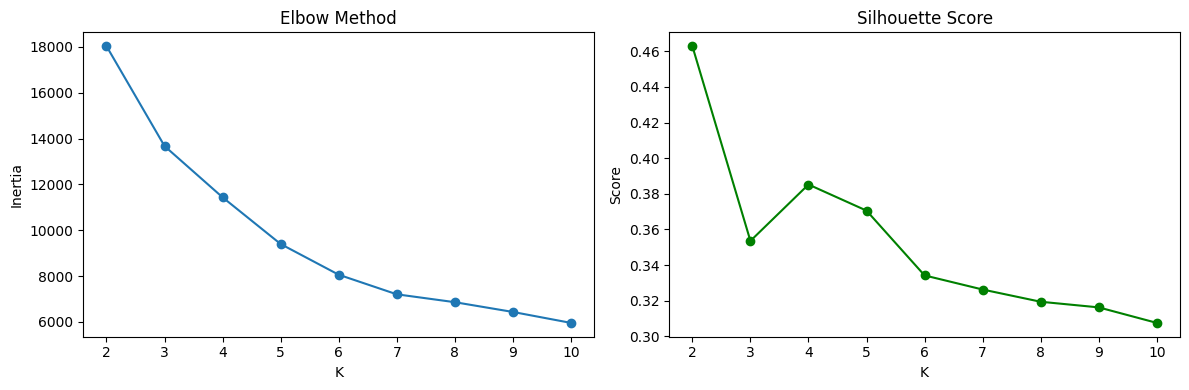

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(K_range, inertia, marker='o')
ax[0].set_title("Elbow Method")
ax[0].set_xlabel("K")
ax[0].set_ylabel("Inertia")

ax[1].plot(K_range, sil_scores, marker='o', color='green')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("K")
ax[1].set_ylabel("Score")

plt.tight_layout()
plt.show()

### *Model Building:*

In [64]:
kmeans = joblib.load('kmeans.pkl')

In [65]:
optimal_k = 4
# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_pca)


In [66]:
# joblib.dump(kmeans,'kmeans.pkl')

#### *Visualize Clusters :*

In [67]:
pca_2d = joblib.load('pca_2.pkl')

In [68]:
# pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_pca)

In [69]:
# joblib.dump(pca_2d,'pca_2.pkl')

In [70]:
tsne = joblib.load('tsne.pkl')

In [71]:
# tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

In [72]:
# joblib.dump(tsne,'tsne.pkl')

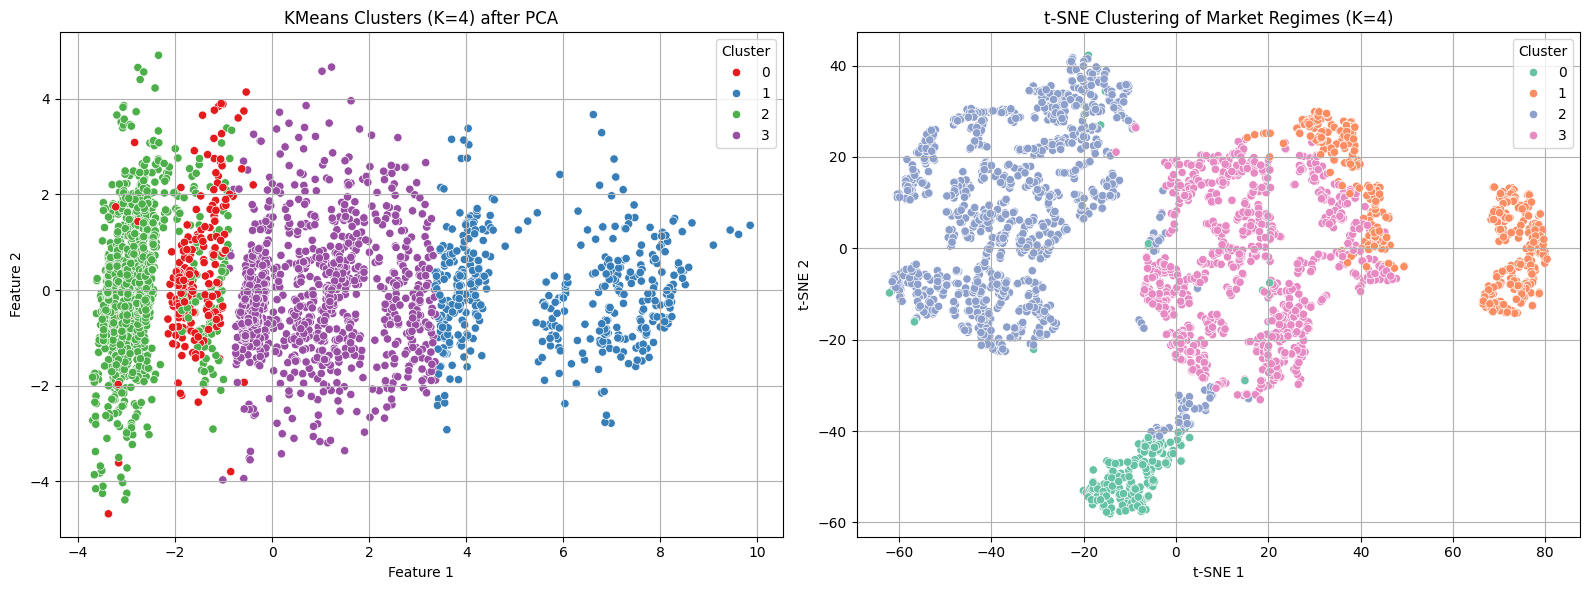

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(
    x=X_2d[:, 0], y=X_2d[:, 1],
    hue=df_cluster['cluster'],
    palette='Set1', ax=axs[0]
)
axs[0].set_title(f'KMeans Clusters (K={optimal_k}) after PCA')
axs[0].set_xlabel("Feature 1")
axs[0].set_ylabel("Feature 2")
axs[0].legend(title='Cluster')
axs[0].grid(True)

sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=df_cluster['cluster'],
    palette='Set2', ax=axs[1]
)
axs[1].set_title(f't-SNE Clustering of Market Regimes (K={optimal_k})')
axs[1].set_xlabel("t-SNE 1")
axs[1].set_ylabel("t-SNE 2")
axs[1].legend(title='Cluster')
axs[1].grid(True)

plt.tight_layout()
plt.show()


### *Clustering Evaluation :*

In [74]:
sil_score = silhouette_score(X_pca, df_cluster['cluster'])
print(f'Silhouette Score: {sil_score:.4f}')

Silhouette Score: 0.3852


In [75]:
db_score = davies_bouldin_score(X_pca, df_cluster['cluster'])
print(f'Davies-Bouldin Index: {db_score:.4f}')

Davies-Bouldin Index: 0.9758


### *Pipeline :*

In [76]:
scaler = joblib.load("clus_scaler.pkl")
pca = joblib.load("pca_1.pkl")
kmeans = joblib.load("kmeans.pkl")

In [77]:
# clustering_pipeline = Pipeline([
#     ('scaler', scaler),
#     ('pca', pca),
#     ('kmeans', kmeans)
# ])

In [78]:
# joblib.dump(clustering_pipeline, 'clustering_pipeline.pkl')

In [79]:
clustering_pipeline = joblib.load('clustering_pipeline.pkl')

In [80]:
clus_df = pd.read_csv('cleaned_data.csv')
clus_df = clus_df.set_index('timestamp')
clus_df.drop(columns=['day', 'target'], inplace=True)

In [81]:
clusters = clustering_pipeline.predict(clus_df)
clus_df['cluster'] = clusters

In [82]:
clus_df.head()

,open,high,low,close,volume,year,returns,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7,cluster
timestamp,,,,,,,,,,,,,,,,
2018-01-14,14210.00,14339.50,12569.20,13474.99,17017.894329,2018,-0.05,14506.92,14370.08,16249.23,14506.92,12764.61,940.96,49.66,-0.17,2
2018-01-15,13477.98,14249.99,13147.79,13539.93,14652.094705,2018,0.00,14124.77,14146.31,15356.54,14124.77,12893.00,665.23,44.25,-0.17,2
2018-01-16,13500.00,13542.93,9035.00,10900.00,63401.169175,2018,-0.19,13930.11,13994.71,15032.60,13930.11,12827.63,595.41,44.83,-0.09,2
2018-01-17,10899.99,11680.99,9037.94,10988.79,72331.796646,2018,0.01,13430.11,13221.04,15740.08,13430.11,11120.15,1247.52,30.94,-0.24,2
2018-01-18,10972.59,11878.82,10435.33,10961.97,48464.434937,2018,-0.00,12870.36,12662.97,15368.72,12870.36,10371.99,1349.27,31.71,-0.26,2


In [83]:
# Load visualizers
pca_2d = joblib.load('pca_2.pkl')
# tsne = joblib.load('tsne.pkl')

In [84]:
X_scaled = clustering_pipeline.named_steps['scaler'].transform(clus_df.drop(columns='cluster'))
X_pca = clustering_pipeline.named_steps['pca'].transform(X_scaled)

In [85]:
# converting to 2d for visualization
X_pca_2d = pca_2d.transform(X_pca)
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_pca)

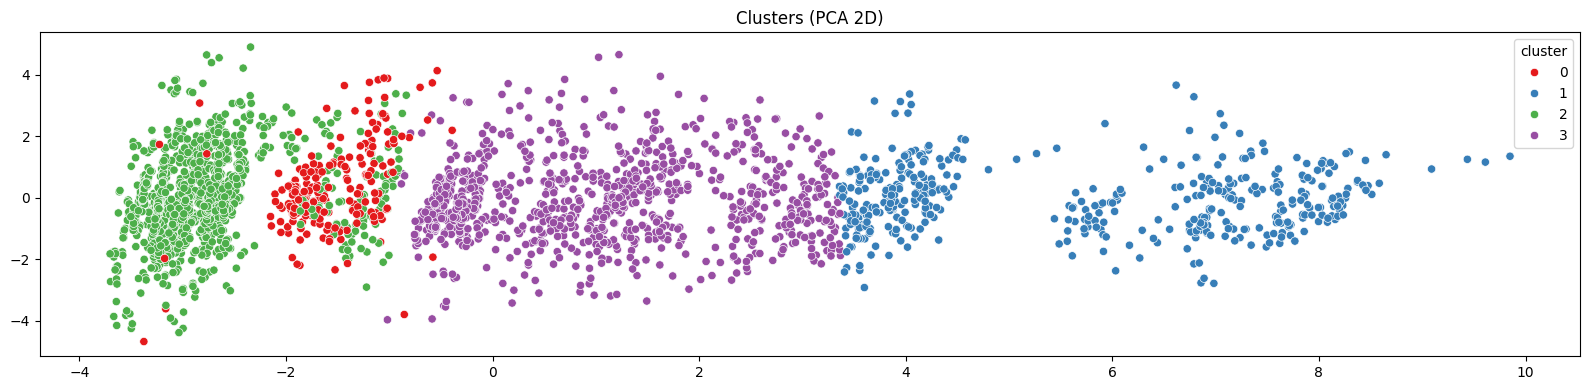

In [86]:
# Plot
plt.figure(figsize=(16,4))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=clus_df['cluster'], palette='Set1')
plt.title('Clusters (PCA 2D)')
plt.tight_layout()
plt.show()

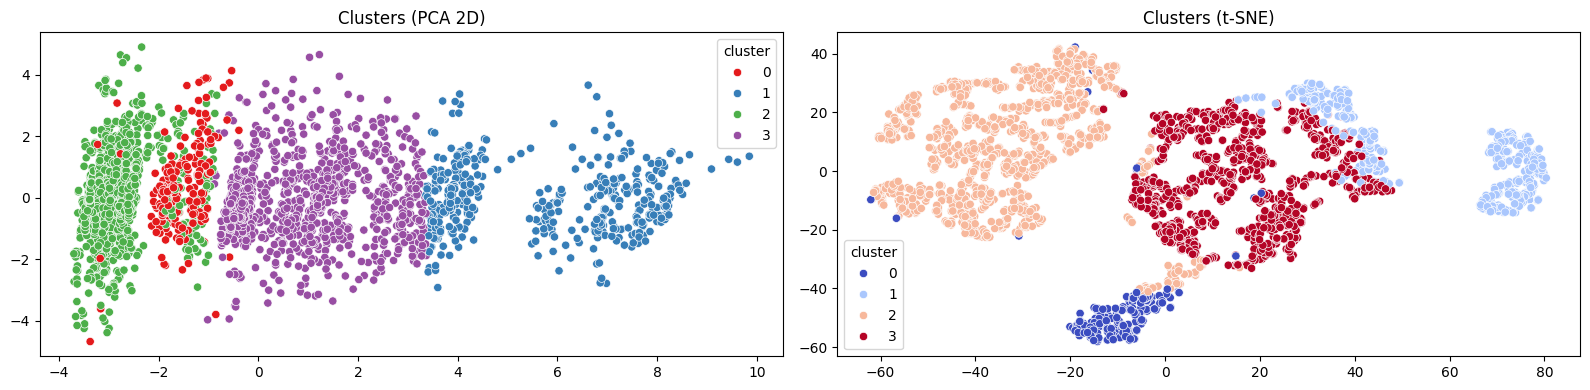

In [87]:
# Plot
fig, axs = plt.subplots(1, 2, figsize=(16,4))

sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=clus_df['cluster'], palette='Set1', ax=axs[0])
axs[0].set_title('Clusters (PCA 2D)')

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clus_df['cluster'], palette='coolwarm', ax=axs[1])
axs[1].set_title('Clusters (t-SNE)')

plt.tight_layout()
plt.show()

In [88]:
sil_score = silhouette_score(X_pca, clus_df['cluster'])
print(f'Silhouette Score: {sil_score:.4f}')

Silhouette Score: 0.3852


In [89]:
db_score = davies_bouldin_score(X_pca, clus_df['cluster'])
print(f'Davies-Bouldin Index: {db_score:.4f}')

Davies-Bouldin Index: 0.9758


### *Insights :*

In [90]:
cluster_summary = clus_df.groupby('cluster').mean()
cluster_summary


,open,high,low,close,volume,year,returns,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7
cluster,,,,,,,,,,,,,,,
0,19911.391773,20353.898473,19434.468079,19880.082020,277563.220738,2022.330049,-0.001626,19829.059852,19841.609803,20951.565911,19829.059852,18706.554581,606.222365,52.178670,0.009212
1,82868.069933,84434.284133,81247.727578,82956.156378,5955.370044,2024.373333,0.001222,82370.498244,82370.835311,86252.375644,82370.498244,78488.621578,2096.453044,55.769489,0.018333
2,9356.405826,9593.794913,9107.736591,9373.950122,49192.208884,2019.212174,0.001696,9334.172626,9338.235165,9950.486930,9334.172626,8717.858426,332.847913,51.221348,0.007983
3,40987.759123,42022.744706,39885.328385,41042.840642,36346.823951,2022.167914,0.001743,40942.728791,40940.947636,43434.193219,40942.728791,38451.264278,1345.544738,51.910107,0.007422


- **Cluster 0 :**

* High volume with negative return = likely panic selling or bearish phase.

- **Cluster 1 :**

* Very high price, low volume = euphoria or parabolic move.
* RSI is rising, and volatility is extremely high (over 2k) → possible blow-off top.

- **Cluster 2 :**

* Low price and low volatility, low return, medium volume = sideways market.
* Market is calm and consolidating.

- **Cluster 3 :**

* Mid-high price with positive return and moderate volatility = healthy trend continuation.

In [91]:
cluster_summary = clus_df.groupby('cluster')[['close','returns','volume','rsi','volatility']].mean()
cluster_summary 


,close,returns,volume,rsi,volatility
cluster,,,,,
0,19880.082020,-0.001626,277563.220738,52.178670,606.222365
1,82956.156378,0.001222,5955.370044,55.769489,2096.453044
2,9373.950122,0.001696,49192.208884,51.221348,332.847913
3,41042.840642,0.001743,36346.823951,51.910107,1345.544738


-  **Cluster 0 :** - Bearish / High Volume (negative return, high vol)

-  **Cluster 1 :** - Bullish  (very high price, low volume)

-  **Cluster 2 :** - Sideways / Stable Period (low vol, steady return)

-  **Cluster 3 :** - Bullish  (moderate price/volatility/return)